In [24]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from collections import Counter, defaultdict
import json, csv
import numpy as np
import xmltodict
from sklearn.dummy import DummyClassifier
import random
from sklearn.metrics import precision_recall_fscore_support
import statsmodels.api as sm
import statsmodels.formula.api as smf


import os
from statistics import mean, stdev
import warnings 
from scipy.stats import ttest_rel, levene
from collections import defaultdict
from typing import List, Dict, Tuple
from scipy import stats
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
from scipy.stats import pearsonr

warnings.filterwarnings('ignore') 

# All analysis on Gemini1.5, 5-s, Task1

In [25]:
all_cases = pd.read_csv('../qualitative_analysis/error_and_correct_both_data.csv')

In [26]:
topic_prf1 = []

for topic in all_cases['dataset'].unique():
    df = all_cases[all_cases['dataset'] == topic]
    pr, re, f1, _ = precision_recall_fscore_support(df['gold'], df['pred'], average='macro')
    
    topic_prf1.append({
        'dataset': topic,
        'precision': pr,
        'recall': re,
        'f1': f1
    })

topic_prf1_df = pd.DataFrame(topic_prf1).round(3)
topic_prf1_df

,dataset,precision,recall,f1
0,gm,0.829,0.771,0.788
1,ugip,0.761,0.726,0.738
2,abortion,0.653,0.818,0.674
3,gayRights,0.624,0.720,0.637
4,marijuana,0.605,0.674,0.614
5,obama,0.606,0.739,0.625


In [27]:
stance_prf1 = []

for stance in ['Pro', 'Con']:
    df = all_cases[all_cases['stance'] == stance]
    pr, re, f1, _ = precision_recall_fscore_support(df['gold'], df['pred'], average='binary')

    stance_prf1.append({
        'stance': stance,
        'precision': pr,
        'recall': re,
        'f1': f1
    })

stance_prf1_df = pd.DataFrame(stance_prf1).round(3)
stance_prf1_df

,stance,precision,recall,f1
0,Pro,0.379,0.631,0.473
1,Con,0.309,0.695,0.427


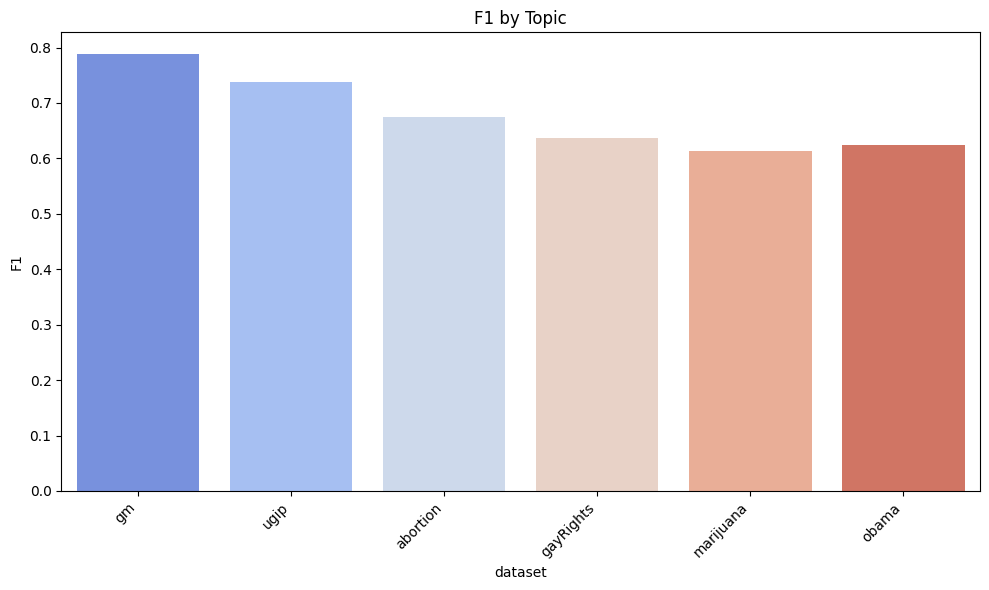

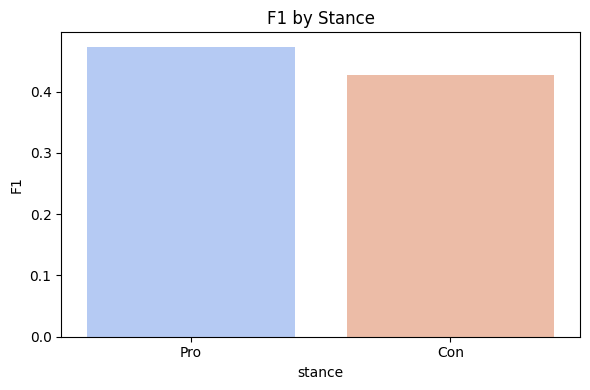

In [28]:
metrics = ['f1']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=topic_prf1_df, x='dataset', y=metric, palette='coolwarm')
    plt.title(f'{metric.capitalize()} by Topic')
    plt.ylabel(f'{metric.capitalize()}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=stance_prf1_df, x='stance', y=metric, palette='coolwarm')
    plt.title(f'{metric.capitalize()} by Stance')
    plt.ylabel(f'{metric.capitalize()}')
    plt.tight_layout()
    plt.show()


In [29]:
all_cases = all_cases[all_cases['argument'] != 'Others']
all_cases

,dataset,split,id,gold,pred,argument,stance,comment,error_type
0,gm,1,74arg1,0,0,Gay couples can declare their union without re...,Con,I think that gay marriage should be allowed in...,correct
1,gm,1,163arg4,0,0,It is discriminatory to refuse gay couples the...,Pro,"Unless... two gay people can create a life, wh...",correct
2,gm,1,113arg4,0,0,It is discriminatory to refuse gay couples the...,Pro,"Marriage:Men and women of full age, without an...",correct
3,gm,1,88arg5,1,1,Major world religions are against gay marriages,Con,"Immorality should never has A SAY,should never...",correct
4,gm,1,77arg7,0,0,Marriage should be between a man and a woman,Con,I'm con actually not because I think governmen...,correct
...,...,...,...,...,...,...,...,...,...
110255,obama,5,oba60arg0,0,1,Fixed the economy.,Pro,Last time I checked that guy that tried to bom...,FP
110256,obama,5,oba57arg13,0,1,Poor decision-maker.,Con,Job Summit today. Basically Obama is saying he...,FP
110260,obama,5,oba3arg4,0,1,Has qualities of a good leader.,Pro,Bill Clinton won approximately the same percen...,FP
110265,obama,5,oba265arg13,0,1,Poor decision-maker.,Con,Thinking of the election that was placed you e...,FP


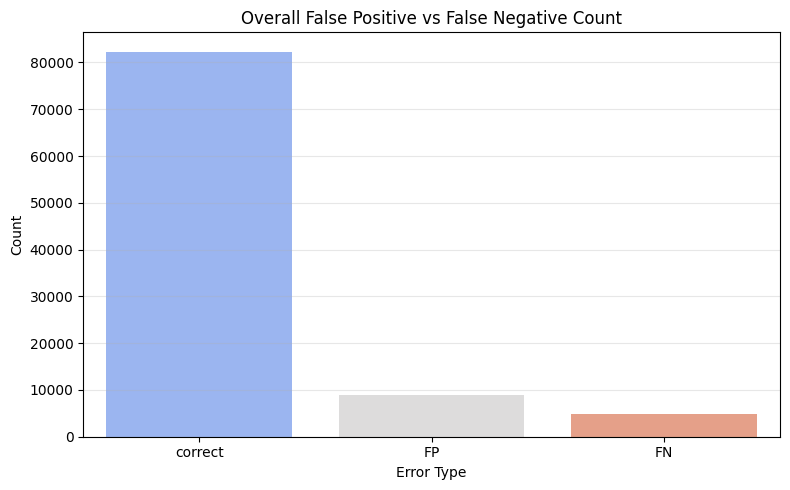

In [30]:
overall_errors = all_cases['error_type'].value_counts().reset_index()
overall_errors.columns = ['error_type', 'count']

plt.figure(figsize=(8, 5))
sns.barplot(data=overall_errors,
            x='error_type', y='count', palette='coolwarm')

plt.title("Overall False Positive vs False Negative Count")
plt.xlabel("Error Type")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

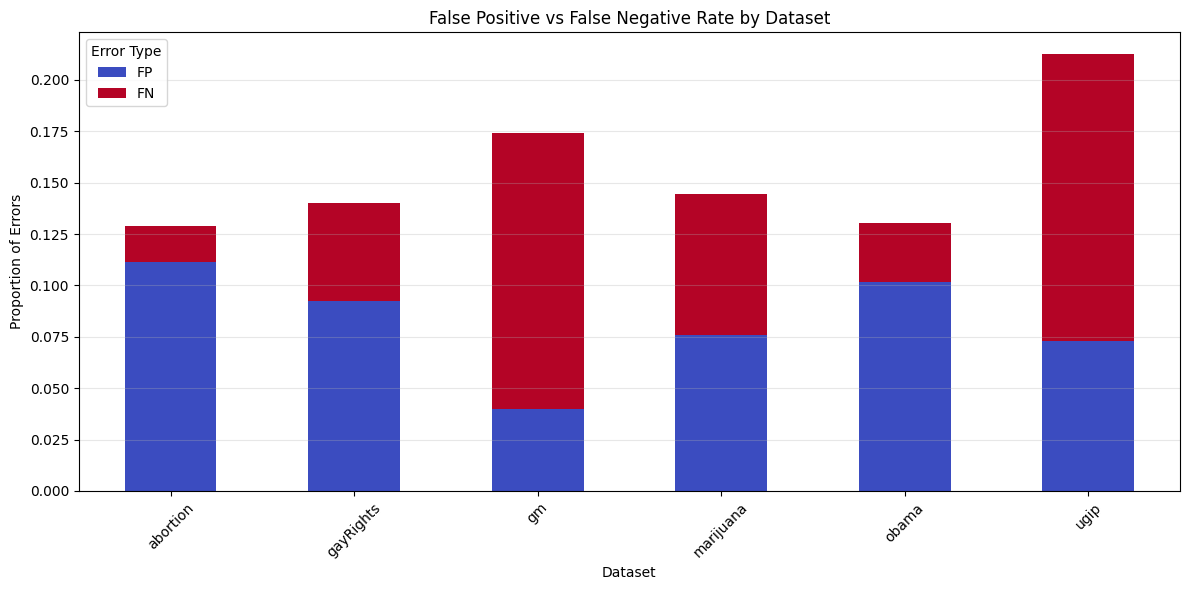

In [31]:
error_dist = all_cases.groupby(['dataset', 'error_type']).size().reset_index(name='count')

error_pivot = error_dist.pivot(index='dataset', columns='error_type', values='count').fillna(0)

error_pct = error_pivot.div(error_pivot.sum(axis=1), axis=0)

plt.figure(figsize=(12, 6))
error_pct[['FP', 'FN']].plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12, 6))
plt.title("False Positive vs False Negative Rate by Dataset")
plt.ylabel("Proportion of Errors")
plt.xlabel("Dataset")
plt.xticks(rotation=45)
plt.legend(title="Error Type")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

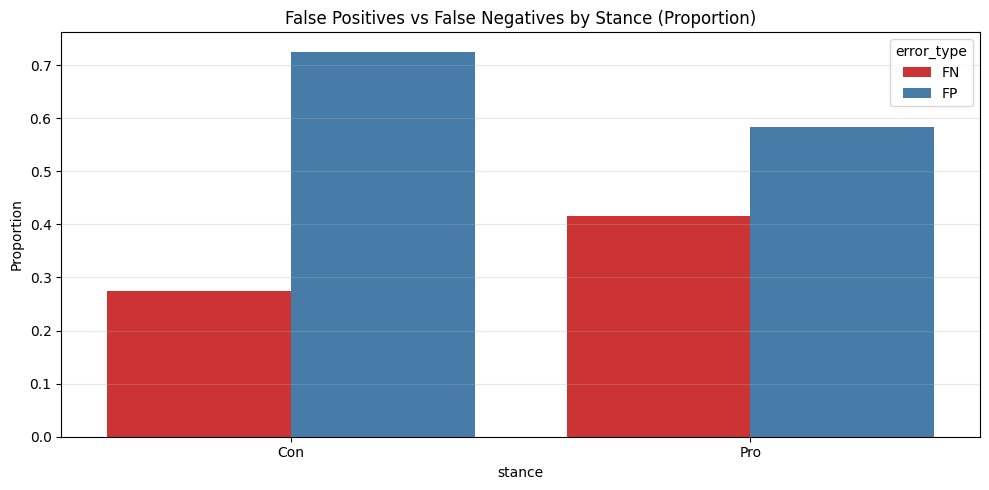

In [32]:
fp_fn_cases = all_cases[all_cases['error_type'].isin(['FP', 'FN'])]

stance_errors = fp_fn_cases.groupby(['stance', 'error_type']).size().reset_index(name='count')

stance_errors_total = stance_errors.groupby('stance')['count'].transform('sum')
stance_errors['proportion'] = stance_errors['count'] / stance_errors_total

plt.figure(figsize=(10, 5))
sns.barplot(data=stance_errors, x='stance', y='proportion', hue='error_type', palette='Set1')
plt.title("False Positives vs False Negatives by Stance (Proportion)")
plt.ylabel("Proportion")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

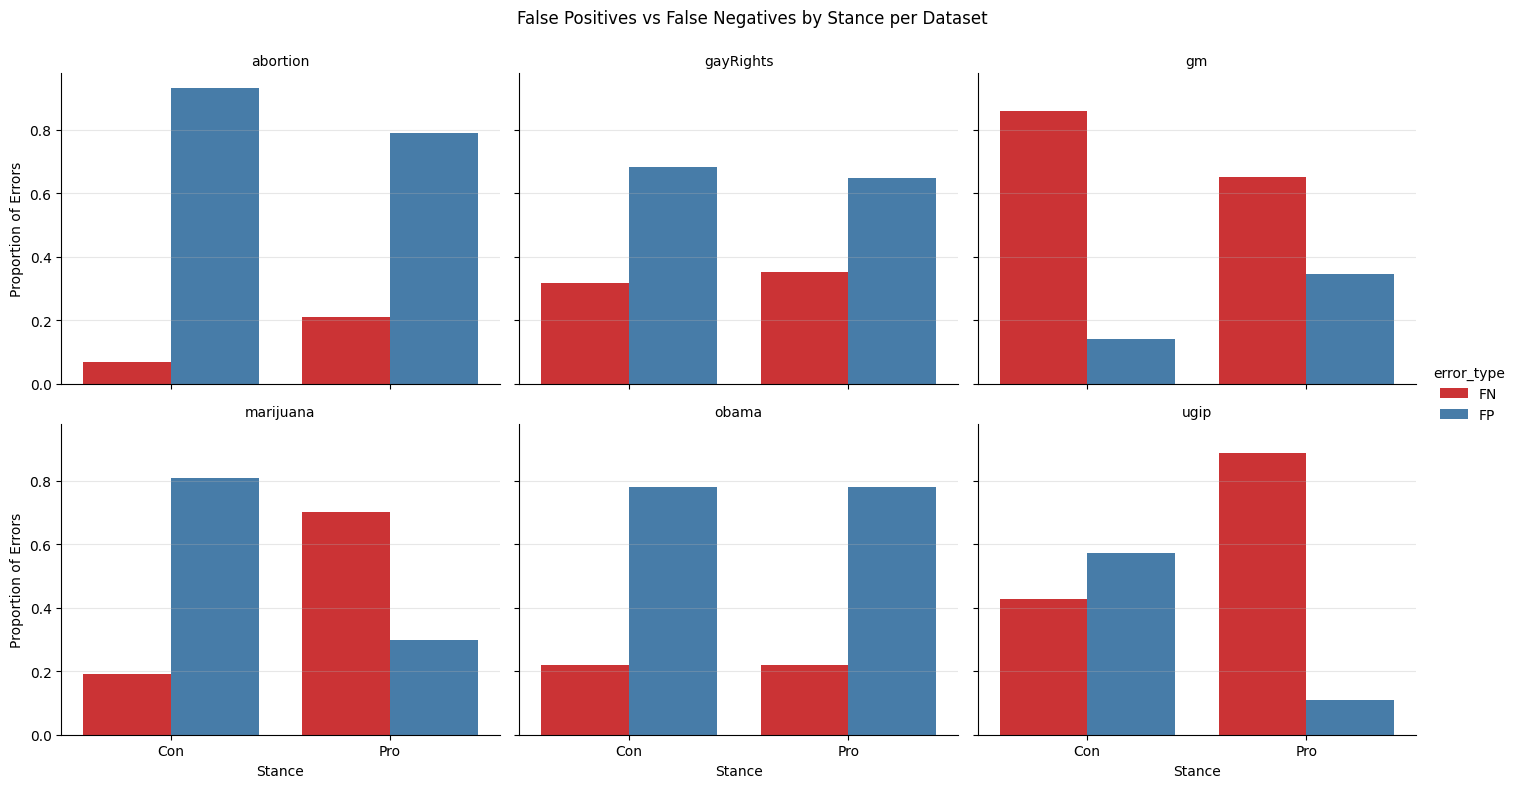

In [33]:
fp_fn_cases = all_cases[all_cases['error_type'].isin(['FP', 'FN'])]

topic_stance_errors = fp_fn_cases.groupby(['dataset', 'stance', 'error_type']).size().reset_index(name='count')

topic_stance_errors['proportion'] = topic_stance_errors.groupby(['dataset', 'stance'])['count'].transform(lambda x: x / x.sum())

g = sns.catplot(
    data=topic_stance_errors,
    x='stance', y='proportion', hue='error_type',
    col='dataset', col_wrap=3,
    kind='bar', height=4, aspect=1.2,
    palette='Set1'
)

g.set_titles("{col_name}")
g.set_axis_labels("Stance", "Proportion of Errors")
g.set_xticklabels(["Con", "Pro"])
for ax in g.axes.flatten():
    ax.grid(axis='y', alpha=0.3)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("False Positives vs False Negatives by Stance per Dataset")

plt.show()

## Quantitative analysis

In [34]:
### 1. Effect of Argument Frequency on Accuracy

arg_counts = all_cases['argument'].value_counts().reset_index()
arg_counts.columns = ['argument', 'frequency']

arg_accuracy = all_cases.groupby('argument').apply(
    lambda x: (x['gold'] == x['pred']).mean()
).reset_index()
arg_accuracy.columns = ['argument', 'accuracy']

arg_analysis = pd.merge(arg_counts, arg_accuracy, on='argument')

corr, p_value = pearsonr(arg_analysis['frequency'], arg_analysis['accuracy'])
print(f"Correlation between argument frequency and accuracy: {corr:.4f} (p={p_value:.4f})")

Correlation between argument frequency and accuracy: 0.2509 (p=0.0512)


- Weak positive effect of frequency

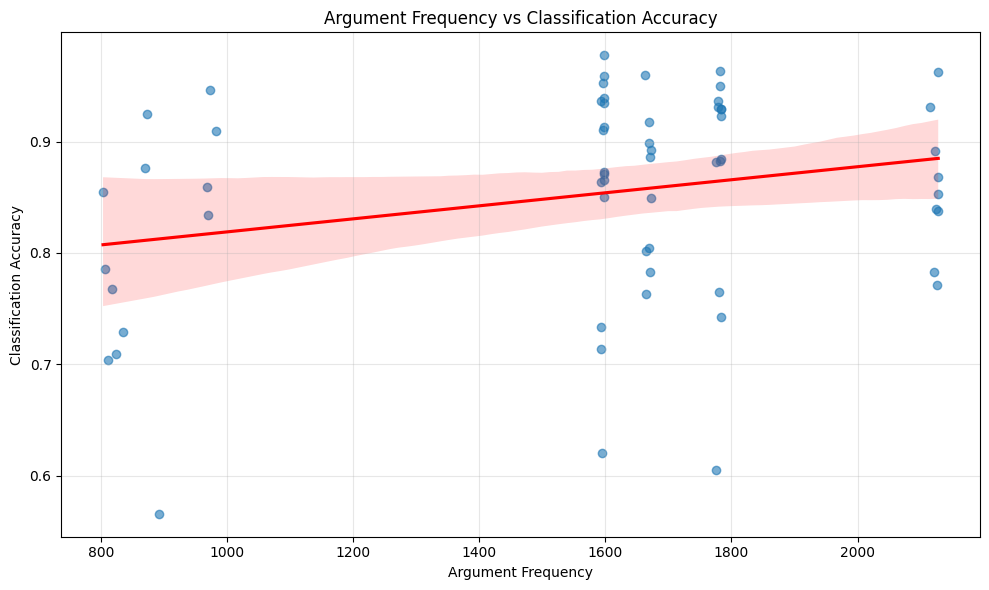

In [35]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=arg_analysis, 
    x='frequency', 
    y='accuracy', 
    scatter_kws={'alpha':0.6}, 
    line_kws={'color':'red'}
)
plt.xlabel('Argument Frequency')
plt.ylabel('Classification Accuracy')
plt.title('Argument Frequency vs Classification Accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [36]:
### 2. Single Argument Performance

worst_args = arg_analysis.sort_values('accuracy').head(10)
best_args = arg_analysis.sort_values('accuracy', ascending=False).head(10)


arg_topics = all_cases.groupby('argument')['dataset'].first().reset_index()
arg_analysis = pd.merge(arg_analysis, arg_topics, on='argument')

topic_counts = all_cases['dataset'].value_counts().reset_index()
topic_counts.columns = ['dataset', 'topic_total']

arg_analysis = pd.merge(arg_analysis, topic_counts, on='dataset')

# Calculate proportion
arg_analysis['topic_proportion'] = arg_analysis['frequency'] / arg_analysis['topic_total']

worst_args = arg_analysis.sort_values('accuracy').head(10)[['argument', 'accuracy', 'frequency', 'topic_proportion', 'dataset']]
best_args = arg_analysis.sort_values('accuracy', ascending=False).head(10)[['argument', 'accuracy', 'frequency', 'topic_proportion', 'dataset']]

print("Most Incorrectly Classified Arguments:")
print(worst_args)
print("\nMost Correctly Classified Arguments:")
print(best_args)

Most Incorrectly Classified Arguments:
                                             argument  accuracy  frequency  \
52       Marriage should be between a man and a woman  0.565657        891   
20                             Abortion kills a life.  0.605293       1776   
43                               Poor decision-maker.  0.620063       1595   
58  America is based on democracy and the pledge s...  0.704069        811   
56                   Separation of state and religion  0.709599        823   
44                    Has qualities of a good leader.  0.713748       1593   
55  Under God  is part of American tradition and h...  0.729341        835   
47                     Makes good decisions/policies.  0.733208       1593   
11  An unborn baby is a human and has the right to...  0.742713       1784   
30                                     Not addictive.  0.762620       1664   

    topic_proportion    dataset  
52          0.139349         gm  
20          0.076700   abortion  


In [37]:
stance_accuracy = all_cases.groupby('stance').apply(
    lambda x: (x['gold'] == x['pred']).mean()
).reset_index()
stance_accuracy.columns = ['stance', 'accuracy']

# Error types by stance
stance_errors = all_cases.groupby(['stance', 'error_type']).size().unstack().fillna(0)
stance_errors_pct = stance_errors.div(stance_errors.sum(axis=1), axis=0)

# Number of predictions by stance and prediction
stance_preds = pd.crosstab(all_cases['stance'], all_cases['pred'])
stance_preds_pct = stance_preds.div(stance_preds.sum(axis=1), axis=0)

print("Accuracy by stance:")
print(stance_accuracy)
print("\nPrediction distribution by stance:")
print(stance_preds_pct)

Accuracy by stance:
  stance  accuracy
0    Con  0.857331
1    Pro  0.859120

Prediction distribution by stance:
pred           0         1
stance                    
Con     0.809693  0.190307
Pro     0.822109  0.177891


- Model tends to underpredict

In [38]:
dataset_accuracy = all_cases.groupby('dataset').apply(
    lambda x: (x['gold'] == x['pred']).mean()
).reset_index()
dataset_accuracy.columns = ['dataset', 'accuracy']

# Error types by dataset
dataset_errors = all_cases.groupby(['dataset', 'error_type']).size().unstack().fillna(0)
dataset_errors_pct = dataset_errors.div(dataset_errors.sum(axis=1), axis=0)

# Cross-dataset analysis with stance
dataset_stance_accuracy = all_cases.groupby(['dataset', 'stance']).apply(
    lambda x: (x['gold'] == x['pred']).mean()
).reset_index()
dataset_stance_accuracy.columns = ['dataset', 'stance', 'accuracy']

print("Accuracy by dataset:")
print(dataset_accuracy)
print("\nError type distribution by dataset:")
print(dataset_errors_pct)

Accuracy by dataset:
     dataset  accuracy
0   abortion  0.871086
1  gayRights  0.859728
2         gm  0.825618
3  marijuana  0.855499
4      obama  0.869557
5       ugip  0.787433

Error type distribution by dataset:
error_type        FN        FP   correct
dataset                                 
abortion    0.017577  0.111337  0.871086
gayRights   0.047594  0.092678  0.859728
gm          0.134657  0.039725  0.825618
marijuana   0.068385  0.076116  0.855499
obama       0.028587  0.101856  0.869557
ugip        0.139590  0.072977  0.787433


<Figure size 1200x600 with 0 Axes>

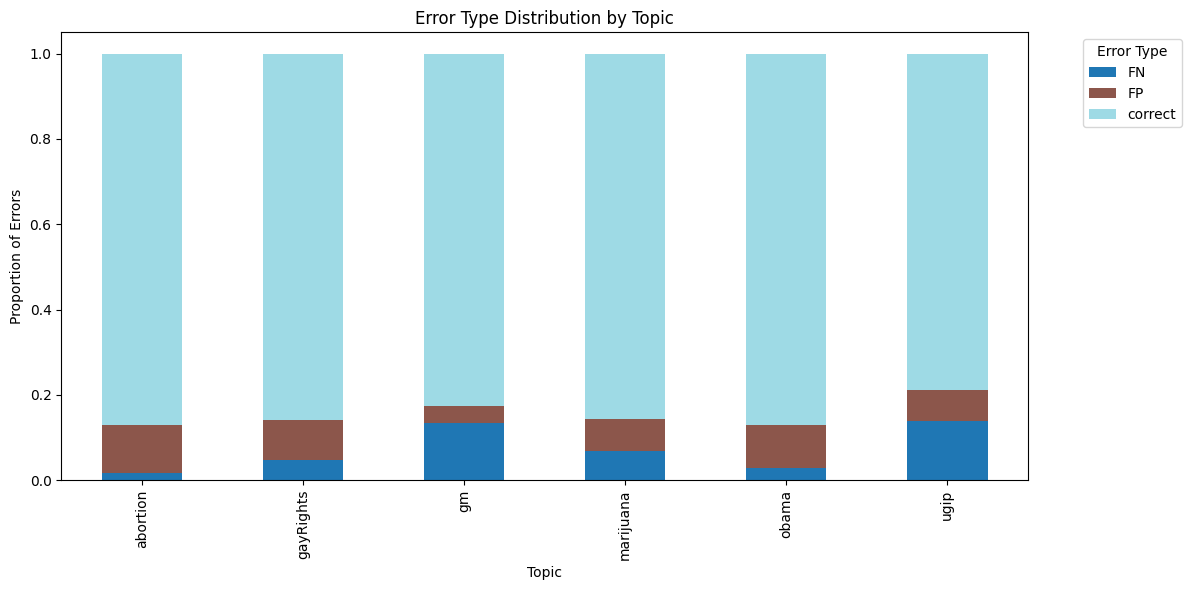

In [39]:
plt.figure(figsize=(12, 6))
dataset_errors_pct.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 6))
plt.title('Error Type Distribution by Topic')
plt.xlabel('Topic')
plt.ylabel('Proportion of Errors')
plt.legend(title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [40]:
argument_metrics = all_cases.groupby('argument').agg({
    'id': 'count',  
    'error_type': lambda x: (x == 'correct').mean(),  # accuracy
    'pred': 'mean',  # average prediction (shows bias toward 0 or 1)
    'gold': 'mean'   # actual distribution
}).reset_index()

argument_metrics = argument_metrics.rename(columns={
    'id': 'frequency',
    'error_type': 'accuracy'
})

error_by_arg = all_cases.groupby(['argument', 'error_type']).size().unstack(fill_value=0)
error_by_arg_pct = error_by_arg.div(error_by_arg.sum(axis=1), axis=0)

if 'FP' in error_by_arg_pct.columns and 'FN' in error_by_arg_pct.columns:
    argument_metrics = argument_metrics.merge(
        error_by_arg_pct[['FP', 'FN']], 
        left_on='argument', 
        right_index=True
    )

best_args = argument_metrics.sort_values('accuracy', ascending=False).head(10)
worst_args = argument_metrics.sort_values('accuracy', ascending=True).head(10)

common_args = argument_metrics[argument_metrics['frequency'] > 100].sort_values('accuracy')

fp_heavy = argument_metrics.sort_values('FP', ascending=False).head(10) if 'FP' in argument_metrics.columns else None
fn_heavy = argument_metrics.sort_values('FN', ascending=False).head(10) if 'FN' in argument_metrics.columns else None

In [41]:
fp_heavy

,argument,frequency,accuracy,pred,gold,FP,FN
4,Abortion kills a life.,1776,0.605293,0.618806,0.231982,0.390766,0.003941
46,Poor decision-maker.,1595,0.620063,0.397492,0.062696,0.357367,0.022571
29,Has qualities of a good leader.,1593,0.713748,0.369115,0.105461,0.274953,0.011299
39,Makes good decisions/policies.,1593,0.733208,0.313873,0.080979,0.249843,0.016949
3,Abortion is not murder.,1780,0.765169,0.275281,0.040449,0.234831,0.000000
7,An unborn baby is a human and has the right to...,1784,0.742713,0.400785,0.217489,0.220291,0.036996
51,Religion should not be used against gay rights.,2121,0.783121,0.293729,0.093824,0.208392,0.008487
28,Gay people should have the same rights as stra...,2126,0.770931,0.538570,0.356538,0.205550,0.023518
13,Damages our bodies.,1671,0.782765,0.265111,0.093357,0.194494,0.022741
11,Causes crime.,1669,0.804074,0.194727,0.040743,0.174955,0.020971


In [42]:
fn_heavy

,argument,frequency,accuracy,pred,gold,FP,FN
41,Marriage should be between a man and a woman,891,0.565657,0.463524,0.855219,0.021324,0.413019
6,America is based on democracy and the pledge s...,811,0.704069,0.081381,0.352651,0.012330,0.283600
55,Under God is part of American tradition and h...,835,0.729341,0.279042,0.544910,0.002395,0.268263
43,Not addictive.,1664,0.762620,0.069712,0.283053,0.012019,0.225361
54,Separation of state and religion,823,0.709599,0.658566,0.744836,0.102066,0.188335
35,It is discriminatory to refuse gay couples the...,806,0.785360,0.507444,0.627792,0.047146,0.167494
36,Legalized marijuana can be controlled and regu...,1665,0.801802,0.238438,0.334535,0.051051,0.147147
45,People are born gay.,2128,0.868421,0.057331,0.169173,0.009868,0.121711
40,"Marriage is about more than procreation, there...",968,0.859504,0.100207,0.189050,0.025826,0.114669
47,Prohibition violates human rights.,1672,0.849282,0.187799,0.222488,0.058014,0.092703


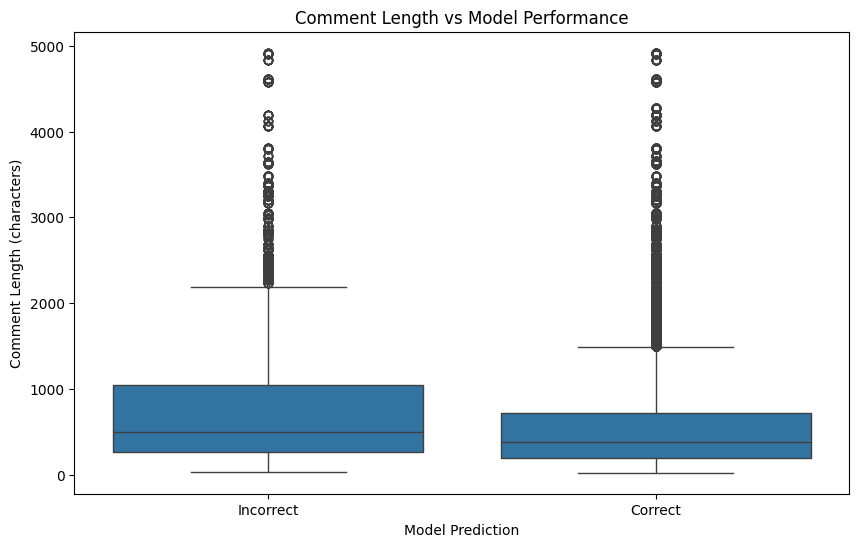

In [43]:
all_cases["comment_length"] = all_cases["comment"].str.len()
all_cases = all_cases[all_cases['comment'].str.len() <= 5000]

all_cases["is_correct"] = all_cases["error_type"].apply(lambda x: 1 if x == "correct" else 0)
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_cases, x="is_correct", y="comment_length")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.xlabel("Model Prediction")
plt.ylabel("Comment Length (characters)")
plt.title("Comment Length vs Model Performance")
plt.show()

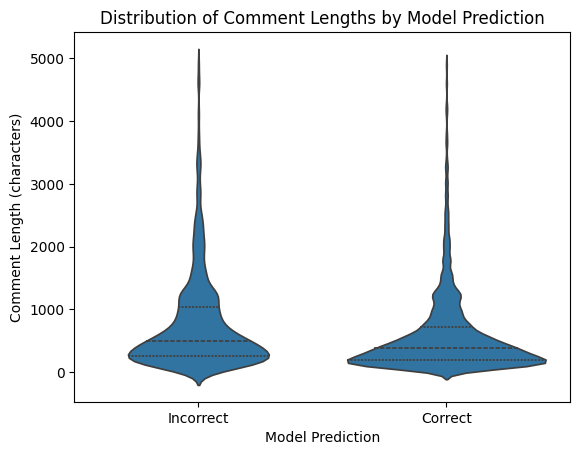

In [44]:
sns.violinplot(data=all_cases, x="is_correct", y="comment_length", inner="quartile")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.xlabel("Model Prediction")
plt.ylabel("Comment Length (characters)")
plt.title("Distribution of Comment Lengths by Model Prediction")
plt.show()

In [45]:
from scipy.stats import ttest_ind

correct_lengths = all_cases[all_cases["is_correct"] == 1]["comment_length"]
incorrect_lengths = all_cases[all_cases["is_correct"] == 0]["comment_length"]

t_stat, p_value = ttest_ind(correct_lengths, incorrect_lengths, equal_var=False)
print(f"T-test result: t={t_stat:.3f}, p={p_value:.4f}")

T-test result: t=-26.171, p=0.0000


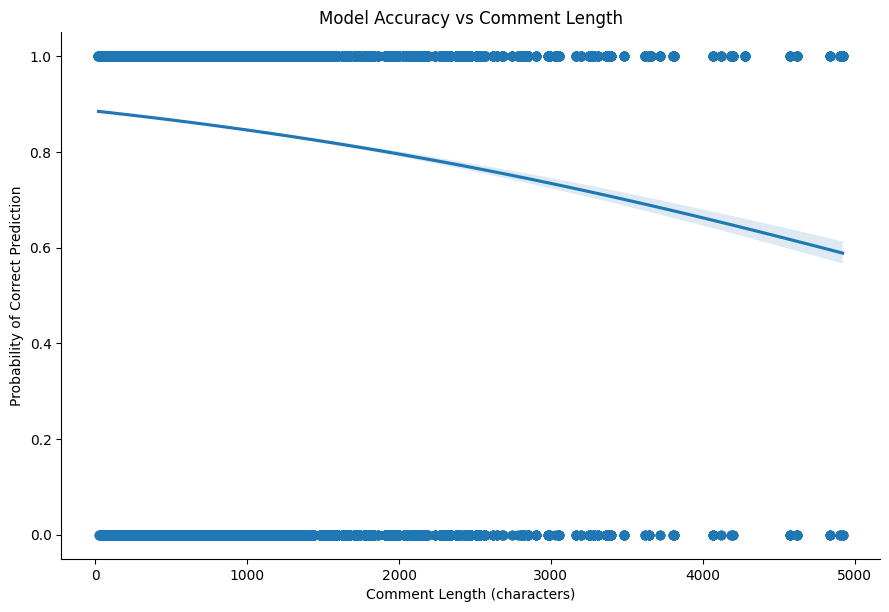

In [46]:
sns.lmplot(data=all_cases, x="comment_length", y="is_correct", logistic=True, height=6, aspect=1.5)
plt.xlabel("Comment Length (characters)")
plt.ylabel("Probability of Correct Prediction")
plt.title("Model Accuracy vs Comment Length")
plt.show()

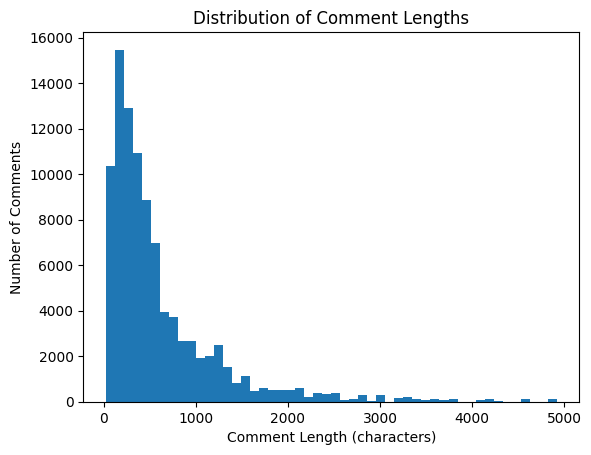

In [47]:
all_cases['comment_length'] = all_cases['comment'].str.len()

plt.hist(all_cases['comment_length'], bins=50)
plt.xlabel('Comment Length (characters)')
plt.ylabel('Number of Comments')
plt.title('Distribution of Comment Lengths')
plt.show()

- We excluded the top 5% longest comments (over 3000 characters) to reduce the influence of outliers. The logistic regression model shows a clear inverse relationship between comment length and model accuracy, with shorter comments more likely to be classified correctly. Although the per-character drop is small, over hundreds/thousands of characters, the effect becomes meaningful

In [49]:
model = smf.logit("is_correct ~ comment_length", data=all_cases).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.401525
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_correct   No. Observations:                95188
Model:                          Logit   Df Residuals:                    95186
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Apr 2025   Pseudo R-squ.:                0.009827
Time:                        16:54:16   Log-Likelihood:                -38220.
converged:                       True   LL-Null:                       -38600.
Covariance Type:            nonrobust   LLR p-value:                5.327e-167
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.0424      0.013    160.298      0.000       2.017       2.067
comment_length    -0.0003   1.19e-05    -28.844      0.000      -0.000      -0.000
==================================================================================
"""

# Qualitative analysis

In [ ]:
error_samples = all_cases[all_cases['error_type'].isin(['FP', 'FN'])].groupby('dataset').apply(
    lambda x: x.sample(min(8, len(x)))
).reset_index(drop=True)

os.makedirs("qualitative_analysis", exist_ok=True)
error_samples.to_csv("qualitative_analysis/error_samples.csv", index=False, encoding='utf-8')